To-do:

1. The effect of k on accuracy
2. The effect of increased training dataset 
3. The effect of different classification algorithm
4. Try SVD



In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image

In [2]:
# Make train and test directories for each subject
for i in range(40):
    filepath = f'ORL/s{i+1}/'
    try:
        os.makedirs(filepath + 'train')
        os.makedirs(filepath + 'test')
    except OSError:
        pass

In [3]:
# SPLITS 5 IMAGES TO TRAIN, 5 IMAGES TO TEST
import random

def split_data(SOURCE, TRAIN_DIR, TEST_DIR, SPLIT_PERCENT):

    # Get a list of image names
    files = []
    for filename in os.listdir(SOURCE):
        filepath = SOURCE + filename
        if filepath.endswith('.pgm'):
            files.append(filename)

    # Define test and train length
    train_length = int(len(files) * SPLIT_PERCENT)
    test_length = int(len(files)-train_length)

    # Shuffle and split
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:train_length]
    testing_set = shuffled_set[-test_length:]

    # move the files
    for filename in training_set:
        os.replace(SOURCE+filename, TRAIN_DIR + filename)
    for filename in testing_set:
        os.replace(SOURCE+filename, TEST_DIR + filename)

# Execute moving files
for i in range(40):
    filepath = f'ORL/s{i+1}/'
    try:
        split_data(filepath, filepath+'train/', filepath+'test/', 0.5)
    except OSError:
        pass

In [4]:
# RESIZE ALL IMAGES FROM 92*112 to 46*56
# RETRIEVE A 2D ARRAY CONTAINING ALL OF THE FLATTENED IMAGES, ALSO RETRIEVING LABELS BASED ON DIRECTORY

def resize(file_path):
    for filename in os.listdir(file_path):
        if len(filename) <= 6:
            # Note: since the renamed filename lengths are always 7 or 8
            im = Image.open(file_path + filename)
            resized_image = im.resize((46, 56))
            resized_image.save(file_path + 'r_' + filename)

def retrieve(file_path, array, labels_array, label):
    for filename in os.listdir(file_path):
        if len(filename) > 6:
            # Note: since the renamed filename lengths are always 7 or 8
            im = Image.open(file_path + filename)
            x = np.asarray(im)
            x = x.flatten()
            index = array.shape[0]-1
            labels_array[index] = label
            array = np.vstack((array, x))
            
    return array, labels_array

training_image_matrix = np.zeros([1, 46*56])
testing_image_matrix = np.zeros([1, 46*56])

training_labels = np.zeros([200])
testing_labels = np.zeros([200])

for i in range(40):
    file_path = f'ORL/s{i+1}/'
    train_path = file_path + 'train/'
    test_path = file_path + 'test/'
    # resize(train_path)
    # resize(test_path)
    training_image_matrix, training_labels = retrieve(train_path, training_image_matrix, training_labels, i+1)
    testing_image_matrix, testing_labels = retrieve(test_path, testing_image_matrix, testing_labels, i+1)

# Trim away the zero row
training_image_matrix = training_image_matrix[1:]
testing_image_matrix = testing_image_matrix[1:]

#  Note to self: Images are described as (w x h), but matrices (and 2D arrays) are described as (rows x cols), which is (h x w)


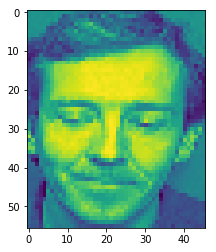

In [5]:
# DEFINING AN IMSHOW METHOD THAT MAKES PLOTTING FACES FASTER
def imshow(image_array, target_shape = None):
    if not target_shape:
        target_shape = (56, 46)
    plt.imshow(np.reshape(image_array, target_shape))

imshow(training_image_matrix[10])

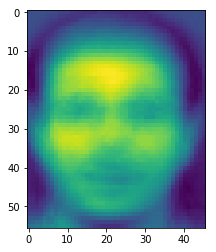

In [6]:
# MEAN IMAGE

mean_image = training_image_matrix.mean(axis = 0)
imshow(mean_image)

In [7]:
# CALCULATE COVARIANCE MATRIX

covariance_matrix = np.zeros([56*46, 56*46])

for i, image_vector in enumerate(training_image_matrix):
    image_vector = image_vector.reshape(1, len(image_vector))
    mean_subtracted_vector = image_vector - mean_image
    covariance = np.matmul(mean_subtracted_vector.transpose(), 
                           mean_subtracted_vector)
    covariance_matrix += covariance

print(covariance_matrix.shape)

(2576, 2576)


In [16]:
# RETRIEVE FIRST k VECTORS

k = 200

W, V = np.linalg.eig(covariance_matrix)
first_k_vectors = V[:,0:k].real
first_k_values = W[0:k]

# first_k_vectors.shape = (2576, 200)

In [9]:
# GET COEFFICIENTS FOR ALL TRAINING IMAGES

coefficient_matrix = np.zeros([1, 200])

for i, image_vector in enumerate(training_image_matrix):
    image_vector = image_vector.reshape(1, len(image_vector))
    coefficients = np.matmul(image_vector, first_k_vectors)
    coefficient_matrix = np.vstack((coefficient_matrix, coefficients))

coefficient_matrix = coefficient_matrix[1:]

# coefficient_matrix.shape = (200, 200)

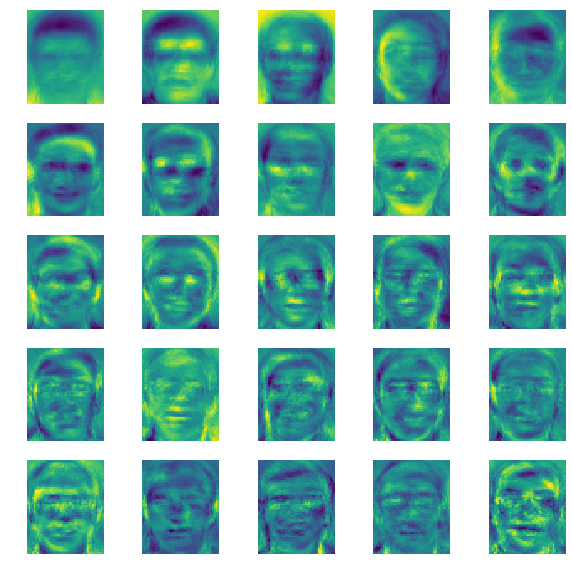

In [14]:
# VISUALISE THE EIGENFACES:

starting_index = 0

fig, axs = plt.subplots(5, 5)
fig.set_size_inches(10,10)

for i, ax in enumerate(axs.flat):
    ax.imshow(first_k_vectors[:, i + starting_index].reshape(56, 46))
    ax.axis('off')

In [11]:
# GET COEFFICIENTS FOR ALL TESTING IMAGES

coefficient_matrix_test = np.zeros([1, 200])

for i, image_vector in enumerate(testing_image_matrix):
    image_vector = image_vector.reshape(1, len(image_vector))
    coefficients = np.matmul(image_vector, first_k_vectors)
    coefficient_matrix_test = np.vstack((coefficient_matrix_test, coefficients))

coefficient_matrix_test = coefficient_matrix_test[1:]

In [17]:
# NEAREST NEIGHBOR

accuracy = 0
predictions = np.zeros(200)
false_indexs = []

for i, coefficients in enumerate(coefficient_matrix_test):

    label = testing_labels[i]
    coefficients = coefficients.reshape(1, 200)

    sum_along_row = np.sum(np.absolute(coefficient_matrix - coefficients), axis = 1)
    min_index = np.argmin(sum_along_row)
    predicted_label = training_labels[min_index]

    predictions[i] = min_index

    if predicted_label == label:
        accuracy += 1
    else:
        false_indexs.append(i)

print(f'Accuracy: {accuracy}/200,  {accuracy / 200}%')


Accuracy: 184/200,  0.92%


In [18]:
# DEFINING METHOD TO VISUALISE PREDICTION

def imshow_prediction(i, first_k_vectors):

    image_vector = testing_image_matrix[i]
    image_label = testing_labels[i]

    closest_image = training_image_matrix[int(predictions[i])]

    coefficients = coefficient_matrix[i]
    reconstructed_x = np.matmul(first_k_vectors, coefficient_matrix[i].reshape(200, 1))  + mean_image.reshape(2576, 1)


    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(15, 5)
    axs[0].imshow(image_vector.reshape(56, 46))
    axs[0].set_title(f'Testing Image, i={i}')

    axs[1].imshow(reconstructed_x.real.reshape(56, 46))
    axs[1].set_title(f'Reconstructed Image')

    axs[2].imshow(closest_image.reshape(56, 46))
    axs[2].set_title(f'Closest Image, i={int(predictions[i])}')

    for ax in axs:
        ax.axis('off')
    
    prediction = image_label == training_labels[int(predictions[i])]
    fig.suptitle(f'Prediction is {str(prediction)}')



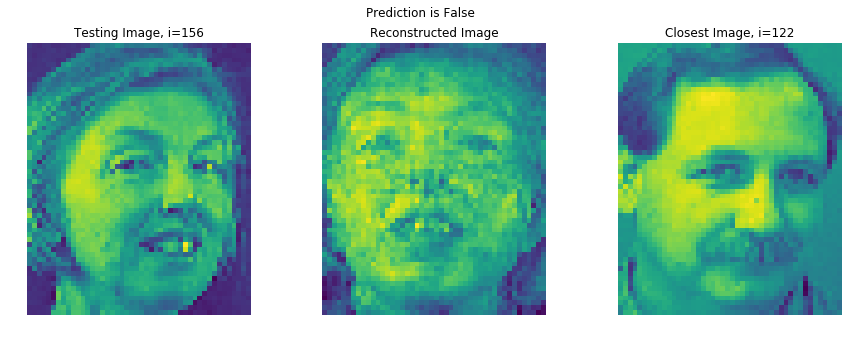

In [56]:
i = np.random.randint(0, 200)

# If you want to see false predictions:
i = np.random.choice(false_indexs)

imshow_prediction(i, first_k_vectors)
